In [21]:
%reset -f

In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np


import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
from tensorflow.keras.layers import Input, Dense, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import Constant
from tensorflow.keras.layers import Layer
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

# from utils.NNSIF_model import get_prediction_model, get_trainable_model, layer_output, fluxes_SIF_predict
from utils.preprocess import include_predictions, div_daynight# , standard_x, split_train_test
from utils.plot import GPP_SIF_dependence # regression_line, 


%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2


plt.rcParams["legend.frameon"] = False
plt.rcParams['savefig.dpi'] = 310
plt.rcParams['font.size'] = 13

2025-04-07 17:09:43.873618: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### 1. import & preprocess the data

In [2]:
data_NN = pd.read_csv('../input_data/test_data_SCOPE.csv',index_col=0,parse_dates=True) 

Variables we need to train & evaluate $NN_{SIF}$

* NN constraints: NEE & SIF
* NN inputs: climate and biotic inputs
* Truth GPP & ER

In [3]:
vars_needed = ['NEE_canopy','SIFcanopy_760nm',      # NN outputs/constraints 
                'Tair','RH','SWC','PAR','LAI','u',  # NN inputs/predictors
                'GPP_canopy','ER_canopy'            # truth values of GPP & ER
                ]
data_NN[vars_needed].head()

,NEE_canopy,SIFcanopy_760nm,Tair,RH,SWC,PAR,LAI,u,GPP_canopy,ER_canopy
2013-06-19 00:00:00,3.462620,0.0000,12.6,94.50072,0.619,0.00,4.221,1.4,0.00,3.462620
2013-06-19 01:00:00,3.361382,0.0000,12.3,95.70137,0.619,0.00,4.221,1.5,0.00,3.361382
2013-06-19 02:00:00,3.267783,0.0000,11.9,93.79667,0.619,0.00,4.221,2.0,0.00,3.267783
2013-06-19 03:00:00,3.188380,0.0000,11.3,92.09961,0.619,0.00,4.221,2.3,0.00,3.188380
2013-06-19 04:00:00,2.700788,0.0093,11.2,88.10334,0.618,10.11,4.221,3.0,0.45,3.150788


devide into training & test sets

In [4]:
train, test          = train_test_split(data_NN, test_size=0.3, random_state=31,shuffle=True)
train['train_label'] = 'Training set'
test['train_label']  = 'Test set'


select model inputs/predictors for training & test sets

* inputs for GPP: air temperature (Tair), relative humidity (RH), soil water content (SWC), photosynthetic active radiation (PAR), wind speed (u), leaf area index (LAI)
* inputs for ER:  Tair, SWC, u, LAI
* inputs for SIF: Tair, RH, SWC
* PAR_label: a label indicative of daytime/nighttime (1 - daytime, 0 - nighttime) 

In [5]:
inputs_GPP  = ['Tair','RH','SWC','PAR','u','LAI'] # inputs for GPP
inputs_ER   = ['Tair','SWC','u','LAI']            # inputs for ER
inputs_SIF  = ['Tair','RH','SWC']                 # inputs for SIF
input_label = 'PAR_label'                         # the label input used for GPP prediction

input_GPP_train = train[inputs_GPP].astype('float32')
input_ER_train  = train[inputs_ER].astype('float32')
input_SIF_train = train[inputs_SIF].astype('float32')
label_train     = train[input_label].astype('float32').values

input_GPP_test = test[inputs_GPP].astype('float32')
input_ER_test  = test[inputs_ER].astype('float32')
input_SIF_test = test[inputs_SIF].astype('float32')
label_test     = test[input_label].astype('float32').values

select model outputs/constraints for training & test sets

In [6]:
NEE_train = train['NEE_canopy'].astype('float32')
SIF_train = train['SIFcanopy_760nm'].astype('float32')

NEE_test = test['NEE_canopy'].astype('float32')
SIF_test = test['SIFcanopy_760nm'].astype('float32')

SCOPE-simulated GPP & ER: used as truth to evaluate $NN_{SIF}$

In [7]:
flux_truth = ['GPP_canopy','ER_canopy']
flux_train= train[flux_truth].astype('float32')
flux_test = test[flux_truth].astype('float32')


standardization for model inputs

In [8]:
def standard_x(x_train,x_test=None):
    
    '''
    This is for input standardization: X' = X - mean(X)/std(X)
    '''
    
    # the mean and std values are only calculated by training set
    x_mean   = x_train.mean(axis=0) 
    x_std    = x_train.std(axis=0)
    x_train1 = ((x_train-x_mean)/x_std).values
    
    if x_test is not None:
        x_test1  = ((x_test -x_mean)/x_std).values
        return x_train1, x_test1
    
    return x_train1 

In [9]:
input_GPP_train,input_GPP_test = standard_x(input_GPP_train,input_GPP_test)
input_ER_train, input_ER_test  = standard_x(input_ER_train, input_ER_test)
input_SIF_train,input_SIF_test = standard_x(input_SIF_train,input_SIF_test)

Normalization for model outputs: $Y_{norm} = Y/max(abs(Y))$ (for the purpose of accelerating training)

In [10]:
NEE_abs_max    = (np.abs(NEE_train.values)).max()
NEE_train_norm = NEE_train.values/NEE_abs_max

SIF_abs_max    = (np.abs(SIF_train.values)).max()
SIF_train_norm = SIF_train.values/SIF_abs_max

### 2. train the $NN_{SIF}$ model

Three components are integral to the design and training of the $NN_{SIF}$ model. 

* func `get_prediction_model`: defines the architecture of the neural network
* class `CustomMultiLossLayer`: implements a multi-task learning loss
* func `get_trainable_model`: integrates the prediction model + the custom loss layer --> trainable model

The `get_prediction_model` function defines the architecture of the neural network, which mainly contains three subnetworks

In [11]:
def get_prediction_model(n_neuron,input_GPP_shape,input_ER_shape,input_SIF_shape,
                         SIF_act=None,SIF_log=False):
    
    '''
    This is to define the structure of the NN_SIF model
    
    Parameters
    ---------- 
    n_neuron:     the number of neurons for each hidden layer
    input_GPP_shape: the shape of the input layer for GPP
    input_ER_shape:  the shape of the input layer for ER
    input_SIF_shape: the shape of the input layer for SIF
    SIF_act:      the activation function for the SIF prediction
    SIF_log:      whether to use a logarithm function for the SIF prediction
    
    Returns:
    ----------
    model: the defined NN_SIF model
    
    '''
    
    # GPP subnetwork
    PAR_label    = Input(shape=(1,), dtype='float32', name='PAR_label')
    input_GPP    = Input(shape=(input_GPP_shape,), dtype='float32', name='input_GPP')
    x            = Dense(n_neuron, activation='relu',name='hidden1_1')(input_GPP)
    x            = Dense(n_neuron, activation='relu',name='hidden1_2')(x)
    ln_GPP       = Dense(1, activation = None, name='ln_GPP')(x)
    GPP_original = Lambda(lambda x: K.exp(x), name='GPP_original')(ln_GPP)
    GPP          = keras.layers.Multiply(name='GPP')([GPP_original,PAR_label])

    # ER subnetwork
    input_ER  = Input(shape=(input_ER_shape,), dtype='float32', name='input_ER')
    x         = Dense(n_neuron, activation='relu',name='hidden2_1')(input_ER) 
    x         = Dense(n_neuron, activation='relu',name='hidden2_2')(x) 
    ln_ER     = Dense(1,  activation=None,name='ln_ER')(x)
    ER        = Lambda(lambda x: K.exp(x),name='ER')(ln_ER)

    NEE       = keras.layers.Subtract(name='NEE')([ER, GPP])
    
    # SIF subnetwork, SIF = f(GPP, environmental inputs)
    input_SIF = Input(shape=(input_SIF_shape,), dtype='float32', name='input_SIF') # receives environmental inputs
    combined  = keras.layers.Concatenate(name='combined')([GPP, input_SIF]) # concatenate GPP and environmental inputs
    x         = Dense(n_neuron, activation='relu',name='hidden3_1')(combined)
    x         = Dense(n_neuron, activation='relu',name='hidden3_2')(x)
    
    # By default, the finaly layer of SIF does not have an activation function, but you can optionally use 
    # a log activation function (ln(SIF)) or a custom activation function
    if SIF_log:
        ln_SIF    = Dense(1,  activation=None,name='ln_SIF')(x)
        SIF       = Lambda(lambda x: K.exp(x),name='SIF')(ln_SIF)
    else:
        SIF       = Dense(1, name='SIF',activation=SIF_act)(x)
    
    model = Model(inputs=[PAR_label,input_GPP,input_ER,input_SIF], outputs=[NEE,SIF])


    return model


The `CustomMultiLossLayer` class implements a multi-task learning framework, allowing the model to simultaneously optimize for multiple outputs (NEE and SIF) by dynamically balancing their respective loss contributions. 

In [12]:
# Custom loss layer
# reference: https://github.com/yaringal/multi-task-learning-example/blob/master/multi-task-learning-example.ipynb
class CustomMultiLossLayer(Layer):
    
    '''
    This is to achieve the multi-task learning
    '''
    
    def __init__(self, nb_logvars=2,nb_outputs=2, **kwargs):
        self.nb_outputs = nb_outputs # number of outputs
        self.nb_logvars = nb_logvars # number of log_vars
        self.is_placeholder = True
        self.mse_nee = tf.keras.metrics.Mean(name='mse_nee')
        self.mse_sif = tf.keras.metrics.Mean(name='mse_sif')
        super(CustomMultiLossLayer, self).__init__(**kwargs)
    
        
    def build(self, input_shape=None):
        # initialise log_vars - they are trainable parameters
        self.log_vars = []
        for i in range(self.nb_logvars):
            # for each log_var, it stands for log(sigma^2) of the corresponding variable (sigma^2 - variance)
            self.log_vars += [self.add_weight(name='log_var' + str(i), shape=(1,),
                                              initializer=Constant(0.), trainable=True)]
        super(CustomMultiLossLayer, self).build(input_shape)


    def multi_loss(self, NEE_true,SIF_true,NEE_pred,SIF_pred):
        loss = 0
        if self.nb_logvars == 2:
            log_var1, log_var2 = self.log_vars # the log_vars are trainable parameters, stand for log(sigma^2)
            precision_NEE = K.exp(-log_var1)  # the weight for NEE: 1/sigma^2 (inverse of variance)
            precision_SIF = K.exp(-log_var2)  # the weight for SIF: 1/sigma^2 (inverse of variance)
            
            # for each term, loss = (1/sigma^2) * (y_true - y_pred)^2 + log(sigma^2)
            # the purpose of adding log(sigma^2): to penalize extremely small sigma^2
            loss = K.sum(precision_NEE * (NEE_true - NEE_pred)**2. + log_var1, -1) + \
                   K.sum(precision_SIF * (SIF_true - SIF_pred)**2. + log_var2, -1) 
              
        return K.mean(loss) 

    def call(self, inputs):
        # metrics: MSE of NEE & SIF
        NEE_true, SIF_true  = inputs[:self.nb_outputs] 
        NEE_pred, SIF_pred  = inputs[self.nb_outputs:2*self.nb_outputs]
        APAR_input = inputs[-1]
        
        MSE_NEE = self.mse_nee(tf.square(NEE_pred-NEE_true)) # tf.square(NEE_pred-NEE_true)
        MSE_SIF = self.mse_sif(K.mean(K.square(SIF_pred*APAR_input-SIF_true)))
        
        self.add_metric(MSE_NEE)
        self.add_metric(MSE_SIF) 
        
        
        if self.nb_logvars ==2:
            loss    = self.multi_loss(NEE_true,SIF_true,NEE_pred,SIF_pred)
        
        self.add_loss(loss, inputs=inputs)
        
        return K.concatenate(inputs, -1)

The `get_trainable_model` function integrates the prediction model and the custom loss layer into a trainable structure, enabling the $NN_{SIF}$ model to learn from data and infer the relationships between environmental variables and carbon fluxes.

In [13]:
def get_trainable_model(prediction_model,input_GPP_shape,input_ER_shape,input_SIF_shape):
    
    '''
    This is to implement the multi-task training for NN_SIF: 
    the weights of NEE & SIF are inferred purely from data
    
    Parameters
    ---------- 
    prediction_model: the defined structure of NN_SIF (the returned variable of the 'get_prediction_model' function)
    input_GPP_shape: the shape of the input layer for GPP
    input_ER_shape: the shape of the input layer for ER
    input_SIF_shape: the shape of the input layer for SIF
    
    Returns:
    ----------
    model: the NN_SIF model to be trained
    
    '''
    
    PAR_label  = Input(shape=(1,), dtype='float32', name='PAR_label')
    input_GPP  = Input(shape=(input_GPP_shape,), dtype='float32', name='input_GPP')
    input_ER   = Input(shape=(input_ER_shape,), dtype='float32', name='input_ER')
    input_SIF  = Input(shape=(input_SIF_shape,), dtype='float32', name='input_SIF')
    
    NEE_pred,SIF_pred = prediction_model([PAR_label,input_GPP,input_ER,input_SIF])
    
    NEE_truth = Input(shape=(1,), name='NEE_truth')
    SIF_truth = Input(shape=(1,), name='SIF_truth')
    
    out      = CustomMultiLossLayer(nb_outputs=2)([NEE_truth,SIF_truth,NEE_pred,SIF_pred,PAR_label])
    
    return Model([PAR_label,input_GPP,input_ER,input_SIF,NEE_truth,SIF_truth], out)



The below cell shows how we jointly use the above three components to define & train our model 

In [14]:
# define model structure
prediction_model = get_prediction_model(n_neuron=64,
                                        input_GPP_shape=input_GPP_train.shape[1],
                                        input_ER_shape =input_ER_train.shape[1],
                                        input_SIF_shape=input_SIF_train.shape[1])

# define the model to be trained
trainable_model  = get_trainable_model(prediction_model,
                                       input_GPP_shape=input_GPP_train.shape[1],
                                       input_ER_shape =input_ER_train.shape[1],
                                       input_SIF_shape=input_SIF_train.shape[1])

trainable_model.compile(optimizer=keras.optimizers.legacy.Adam(lr=0.002), loss=None)

assert len(trainable_model.layers[-1].trainable_weights) == 2  
assert len(trainable_model.losses) == 1


early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
hist = trainable_model.fit([label_train, input_GPP_train, input_ER_train, input_SIF_train,
                            NEE_train_norm, SIF_train_norm], 
                            epochs=60, batch_size=64, verbose=1, validation_split=0.3,
                            callbacks=[early_stopping])

Train on 3210 samples, validate on 1376 samples


2025-04-07 17:10:04.294079: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 17:10:04.325624: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2025-04-07 17:10:04.389397: W tensorflow/c/c_api.cc:291] Operation '{name:'training/Adam/hidden3_1/bias/v/Assign' id:786 op device:{requested: '', assigned: ''} def:{{{node training/Adam/hidden3_1/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training/Adam/hidden3_1/bias/v, training/Adam/hidden3_1/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigg

Epoch 1/60
3210/3210 [==============================] - 0s 108us/sample - loss: 0.0135 - mse_nee: 0.0858 - mse_sif: 0.0207 - val_loss: -0.1937 - val_mse_nee: 0.0079 - val_mse_sif: 0.0061
Epoch 2/60
3210/3210 [==============================] - 0s 30us/sample - loss: -0.2995 - mse_nee: 0.0060 - mse_sif: 0.0039 - val_loss: -0.4104 - val_mse_nee: 0.0050 - val_mse_sif: 0.0025
Epoch 3/60


2025-04-07 17:10:04.772750: W tensorflow/c/c_api.cc:291] Operation '{name:'custom_multi_loss_layer/Mean_1' id:367 op device:{requested: '', assigned: ''} def:{{{node custom_multi_loss_layer/Mean_1}} = Mean[T=DT_FLOAT, Tidx=DT_INT32, _has_manual_control_dependencies=true, keep_dims=false](custom_multi_loss_layer/add_2, custom_multi_loss_layer/Const_2)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


3210/3210 [==============================] - 0s 30us/sample - loss: -0.5123 - mse_nee: 0.0040 - mse_sif: 0.0019 - val_loss: -0.6205 - val_mse_nee: 0.0038 - val_mse_sif: 0.0014
Epoch 4/60
3210/3210 [==============================] - 0s 30us/sample - loss: -0.7210 - mse_nee: 0.0031 - mse_sif: 0.0013 - val_loss: -0.8274 - val_mse_nee: 0.0034 - val_mse_sif: 0.0011
Epoch 5/60
3210/3210 [==============================] - 0s 31us/sample - loss: -0.9277 - mse_nee: 0.0026 - mse_sif: 0.0011 - val_loss: -1.0337 - val_mse_nee: 0.0030 - val_mse_sif: 0.0010
Epoch 6/60
3210/3210 [==============================] - 0s 29us/sample - loss: -1.1340 - mse_nee: 0.0023 - mse_sif: 9.0937e-04 - val_loss: -1.2399 - val_mse_nee: 0.0026 - val_mse_sif: 7.7184e-04
Epoch 7/60
3210/3210 [==============================] - 0s 29us/sample - loss: -1.3401 - mse_nee: 0.0019 - mse_sif: 7.1382e-04 - val_loss: -1.4455 - val_mse_nee: 0.0023 - val_mse_sif: 6.3825e-04
Epoch 8/60
3210/3210 [==============================] - 0s 3

### 3. predict carbon fluxes using the well-trained model

Below two functions are used to retrieve the NN-estimated NEE, SIF, GPP and ER. 

* func `get_layer_output`: obtain the intermediate layer output from a trained model
* func `fluxes_SIF_predict`: obtain the predicted NEE, SIF, GPP, and ER. 

In [15]:
def get_layer_output(model,layer_name, PAR_label,input_GPP,input_ER,input_SIF):
    
    '''
    To retrieve the output predicted by a specified NN layer
    
    Parameters
    ---------- 
    model:      the well-trained model
    layer_name: the layer of which output we want to obtain  
    PAR_label:  the 'PAR_label' input 
    input_GPP:  the input data for GPP estimation
    input_ER:   the input data for ER estimation
    input_SIF:  the input data for the estimation of the GPP-SIF relationship
    
    Returns:
    ---------- 
    layer_output: the prediction of the specifed layer
    
    '''
    
    layer_model  = Model(inputs =model.input,
                         outputs=model.get_layer(layer_name).output)
    layer_output = layer_model.predict({'PAR_label':  PAR_label,
                                        'input_GPP':  input_GPP,
                                        'input_ER':   input_ER,
                                        'input_SIF':  input_SIF})
    return layer_output


In [16]:
def fluxes_SIF_predict(model,PAR_label,input_GPP, input_ER, input_SIF, 
                       NEE_abs_max, SIF_abs_max):
    
    '''
    To predict GPP, ER & SIF using the well-trained NN_SIF model
    
    Parameters
    ----------
    model:      the well-trained NN_SIF model
    PAR_label: the 'PAR_label' input
    input_GPP:  input data for GPP estimation
    input_ER:   input data for ER estimation
    input_SIF:  input data for the estimation of the GPP-SIF relationship
    NEE_max_abs: the max value of abs(NEE), which is used to convert back to the real value of NEE
    SIF_max_abs: the max value of abs(SIF), which is used to convert back to the real value of SIF
    
    Returns:
    ---------- 
    NEE_NN:  the NN-predicted NEE 
    GPP_NN:  the NN-predicted GPP 
    ER_NN:   the NN-predicted ER
    SIF_NN:  the NN-predicted SIF
    '''
    
    NEE_NN  = (get_layer_output(model,'NEE',PAR_label,input_GPP,input_ER,input_SIF) * NEE_abs_max)
    NEE_NN  = NEE_NN.reshape(NEE_NN.shape[0],)
    
    GPP_NN  = (get_layer_output(model,'GPP',PAR_label,input_GPP,input_ER,input_SIF) * NEE_abs_max).reshape(NEE_NN.shape[0],)
    ER_NN   = (get_layer_output(model,'ER', PAR_label,input_GPP,input_ER,input_SIF) * NEE_abs_max).reshape(NEE_NN.shape[0],)
    SIF_NN  = (get_layer_output(model,'SIF',PAR_label,input_GPP,input_ER,input_SIF) * SIF_abs_max).reshape(NEE_NN.shape[0],)
    

    return NEE_NN, GPP_NN, ER_NN, SIF_NN

In [17]:
NEE_trainNN, GPP_trainNN, Reco_trainNN, SIF_trainNN = fluxes_SIF_predict(prediction_model,label_train,
                                                                         input_GPP_train, input_ER_train, input_SIF_train,
                                                                         NEE_abs_max, SIF_abs_max)
NEE_testNN, GPP_testNN, Reco_testNN, SIF_testNN = fluxes_SIF_predict(prediction_model,label_test,
                                                                     input_GPP_test, input_ER_test, input_SIF_test,
                                                                     NEE_abs_max, SIF_abs_max)



train = include_predictions(train,NEE_trainNN, GPP_trainNN, Reco_trainNN, SIF_trainNN)
test  = include_predictions(test,NEE_testNN, GPP_testNN, Reco_testNN, SIF_testNN)

# save the data
data_NN = pd.concat([train,test],axis=0).sort_index()
day_SC, night_SC = div_daynight(data_NN)

2025-04-07 17:10:13.476448: W tensorflow/c/c_api.cc:291] Operation '{name:'NEE/sub' id:150 op device:{requested: '', assigned: ''} def:{{{node NEE/sub}} = Sub[T=DT_FLOAT, _has_manual_control_dependencies=true](ER/Exp, GPP/mul)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-04-07 17:10:13.609567: W tensorflow/c/c_api.cc:291] Operation '{name:'GPP/mul' id:76 op device:{requested: '', assigned: ''} def:{{{node GPP/mul}} = Mul[T=DT_FLOAT, _has_manual_control_dependencies=true](GPP_original/Exp, PAR_label)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2025-04-07 17:10:13.719354: W tensorflow/c/c_api.cc:291] Operation '{name:'ER/Exp' id:149 op device:{requeste

### 4. evaluate the model predictions

Compare the NN-estimated carbon fluxes against the SCOPE reference values

In [18]:
def plot_time_series(data, var_NN, var_SCOPE,var_str,var_unit):

    # Identify the gap in the data
    gap_start = data.index[data.index.year == 2013][-1]
    gap_end = data.index[data.index.year == 2014][0]

    # Create the plot with a broken x-axis
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(10, 4), gridspec_kw={'width_ratios': [5, 5.5]})

    # Plot the data before the gap
    data.loc[:gap_start, var_NN].plot(ax=ax1, label='$NN_{SIF}$ estimation', color='blue', alpha=0.7)
    data.loc[:gap_start, var_SCOPE].plot(ax=ax1, label='SCOPE', color='orange', alpha=0.7)

    # Plot the data after the gap
    data.loc[gap_end:, var_NN].plot(ax=ax2, label='$NN_{SIF}$ estimation', color='blue', alpha=0.7)
    data.loc[gap_end:, var_SCOPE].plot(ax=ax2, label='SCOPE', color='orange', alpha=0.7)

    # Add labels and titles
    ax1.set_xlabel('Time (2013)')
    ax2.set_xlabel('Time (2014)')
    ax1.set_ylabel(f'{var_str} ({var_unit})')

    # Add a cut indicator
    ax1.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax1.yaxis.tick_left()
    ax2.yaxis.tick_right()
    ax1.tick_params(labelright=False)
    ax2.tick_params(labelleft=False)

    # Set consistent xticks for both axes
    xticks = pd.date_range(start='2013-06-01', end='2013-11-01', freq='2M')
    ax1.set_xticks(xticks)
    ax1.set_xticklabels([tick.strftime('%b %Y') for tick in xticks], rotation=45)

    xticks = pd.date_range(start='2014-05-01', end='2014-11-01', freq='2M')
    ax2.set_xticks(xticks)
    ax2.set_xticklabels([tick.strftime('%b %Y') for tick in xticks], rotation=45)

    d1 = 0.015  # Size of the diagonal lines for ax1
    d2 = 0.015  # Size of the diagonal lines for ax2 (same as d1 to make them parallel)

    kwargs = dict(transform=ax1.transAxes, color='k', clip_on=False)
    ax1.plot((1 - d1, 1 + d1), (-d1, +d1), **kwargs)  # Top-right diagonal
    ax1.plot((1 - d1, 1 + d1), (1 - d1, 1 + d1), **kwargs)  # Bottom-right diagonal

    kwargs.update(transform=ax2.transAxes)  # Switch to the second axis
    ax2.plot((-d2, +d2), (-d2, +d2), **kwargs)  # Top-left diagonal
    ax2.plot((-d2, +d2), (1 - d2, 1 + d2), **kwargs)  # Bottom-left diagonal

    # Adjust layout
    plt.tight_layout()
    plt.legend()

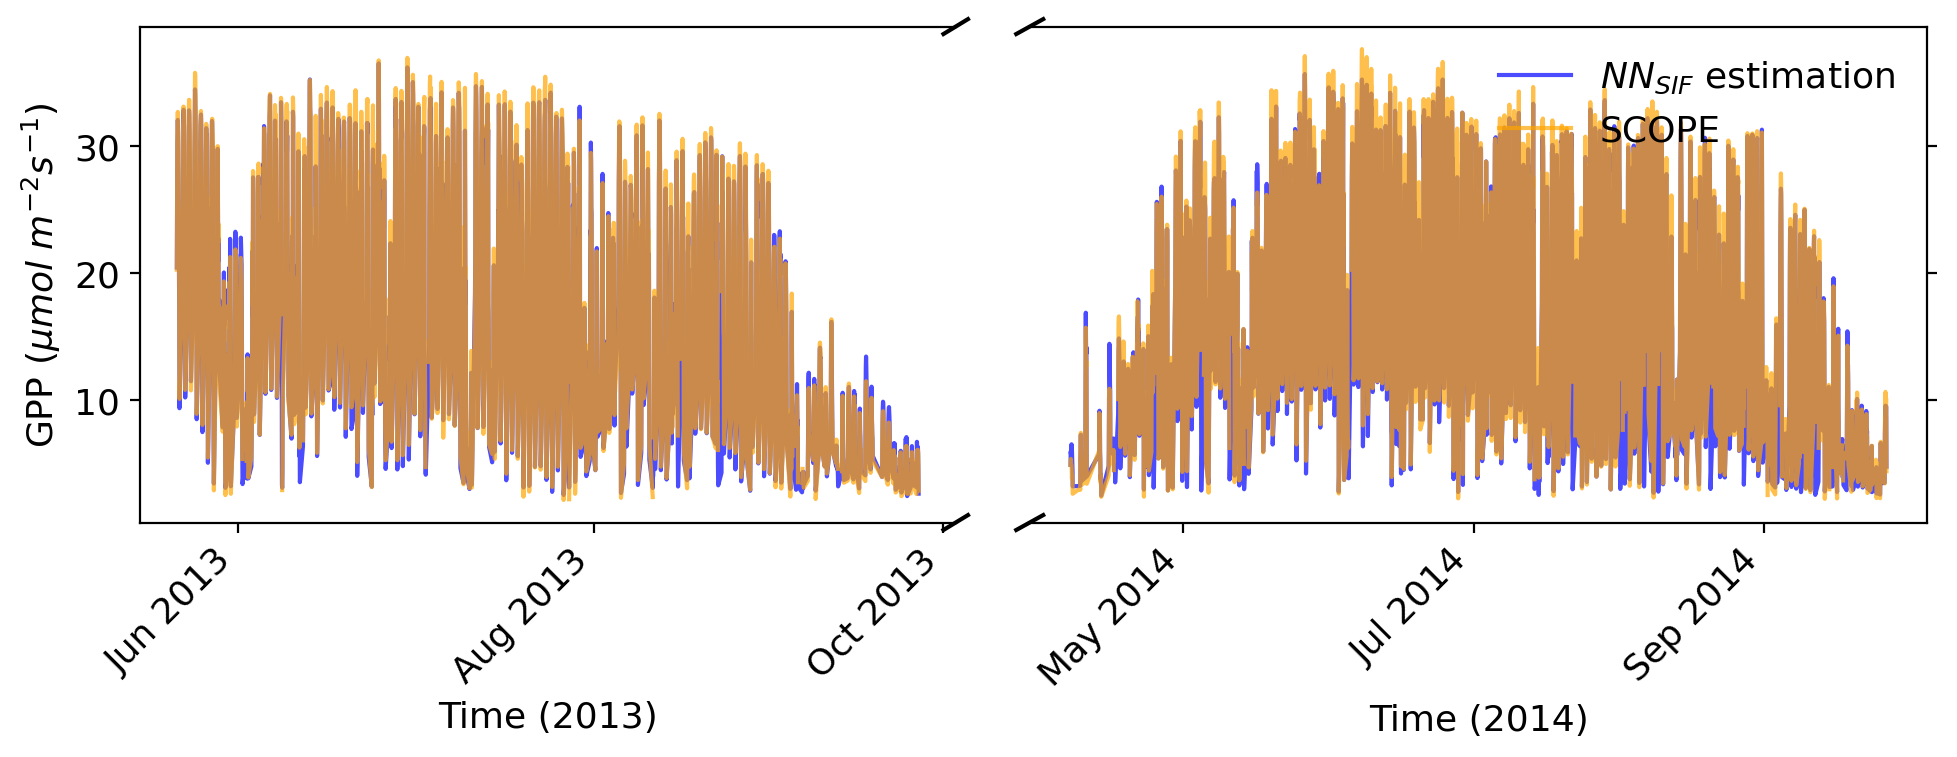

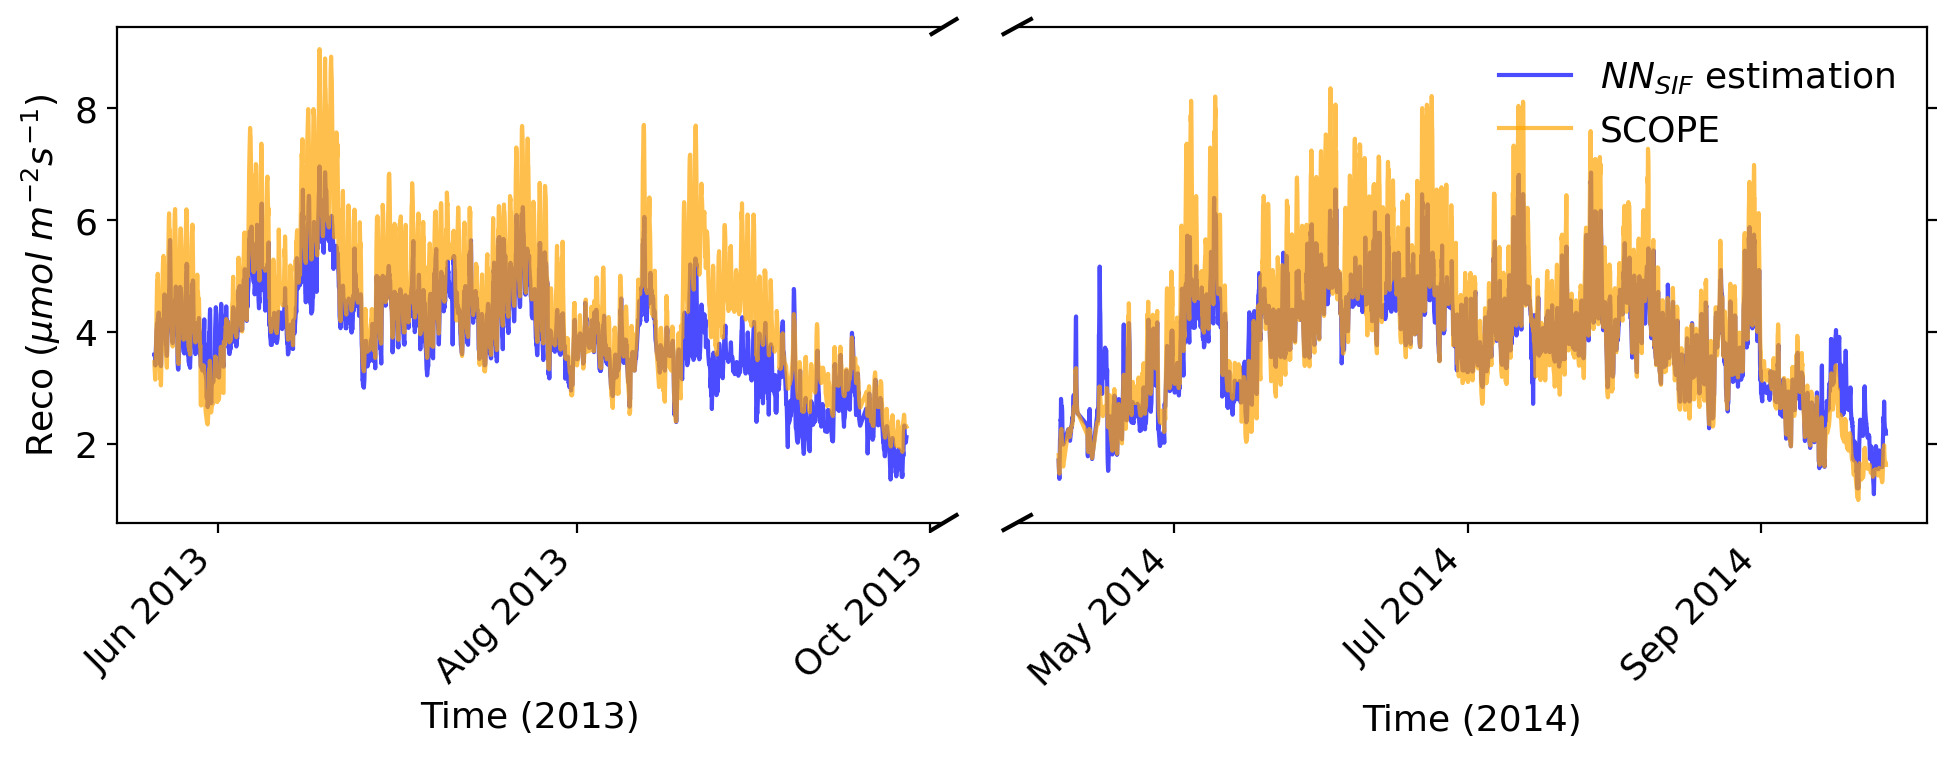

In [19]:
plot_time_series(day_SC, 'GPP_NN', 'GPP_canopy','GPP','$\mu mol$ $m^{-2} s^{-1}$')

plot_time_series(data_NN, 'Reco_NN', 'ER_canopy','Reco','$\mu mol$ $m^{-2} s^{-1}$')

Check the retrieved GPP-SIF relationship

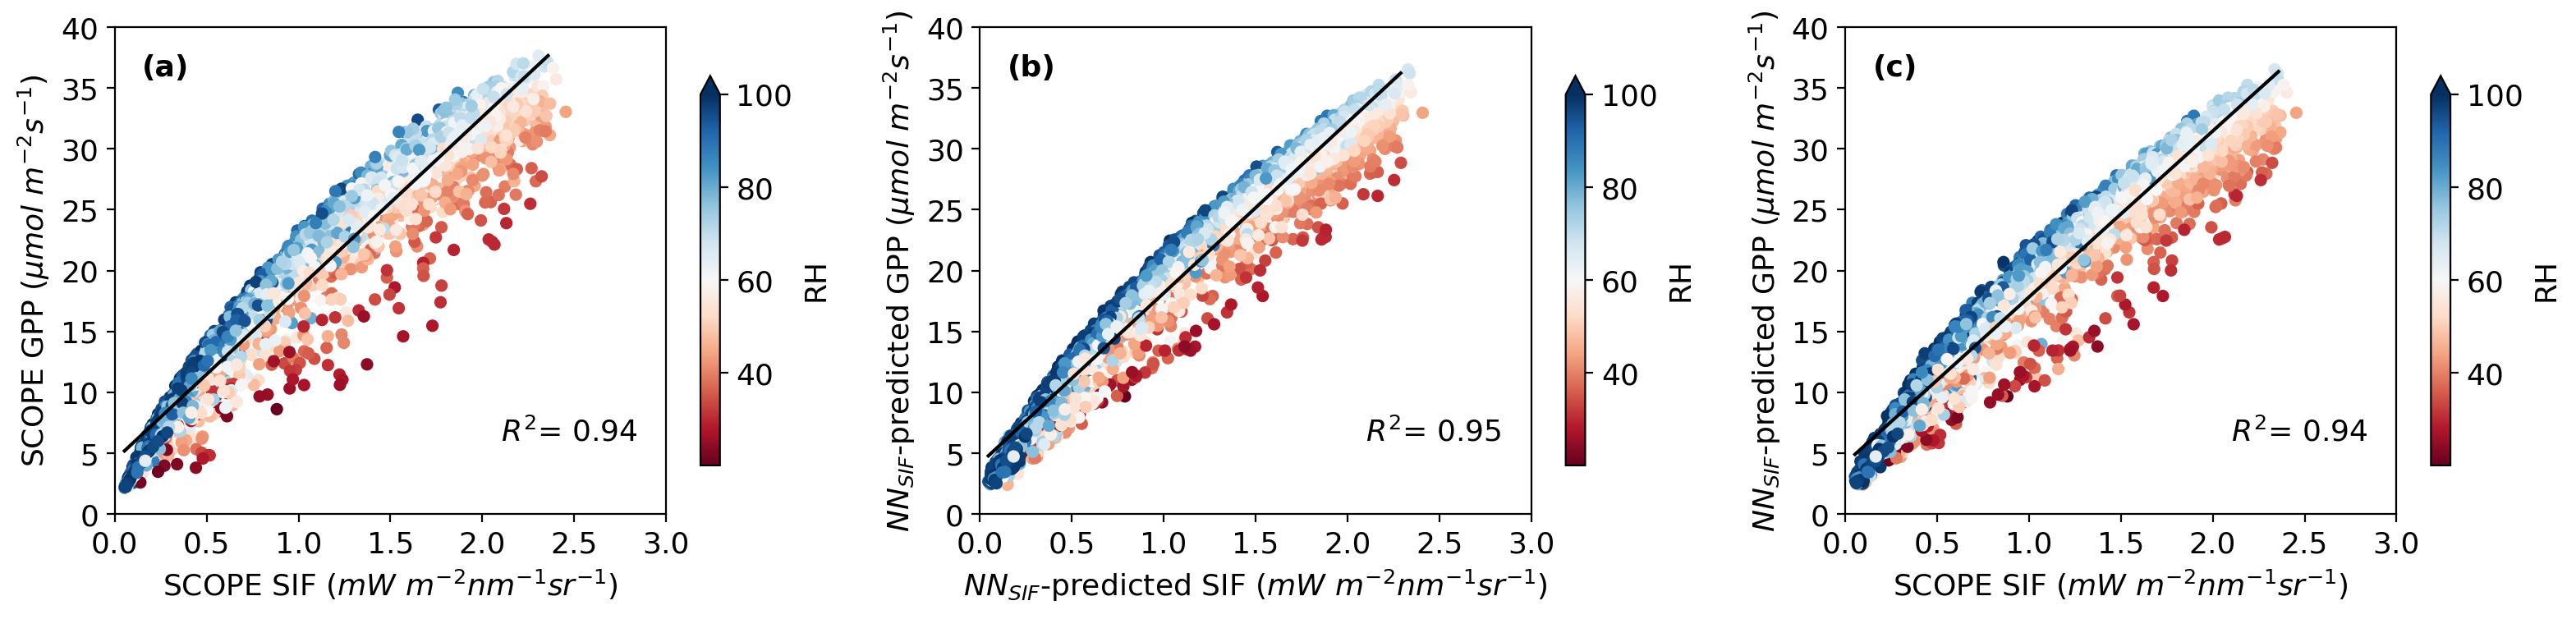

In [20]:
fig, axes = plt.subplots(figsize=(16,4),ncols=3)

xlim = [0,3]
ylim = [0,40]

GPP_SIF_dependence(day_SC,'SIFcanopy_760nm','GPP_canopy',axes[0],'RH','RdBu',fig,'RH',s=20)
GPP_SIF_dependence(day_SC,'SIF_NN','GPP_NN',axes[1],'RH','RdBu',fig,'RH',s=20) 
GPP_SIF_dependence(day_SC,'SIFcanopy_760nm','GPP_NN',axes[2],'RH','RdBu',fig,'RH',s=20) 


xlabel = ['SCOPE SIF', '$NN_{SIF}$-predicted SIF', 'SCOPE SIF']
xunit  = [' ($mW \ m^{-2} nm^{-1} sr^{-1}$)']

ylabel = ['SCOPE GPP', '$NN_{SIF}$-predicted GPP', '$NN_{SIF}$-predicted GPP']
yunit = [' ($\mu mol$ $m^{-2} s^{-1}$)']
num_seq = ['(a)','(b)','(c)','(d)']
for i,ax in enumerate(axes):
    ax.set_xlabel(xlabel[i]+xunit[0])
    ax.set_ylabel(ylabel[i]+yunit[0])
    ax.annotate(num_seq[i],xy=(.05,.9), xycoords='axes fraction',fontweight='bold',fontsize=13)
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
plt.tight_layout()
